In [1]:
# Dependencies

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pickle

from DataSource import DataSource
from cnn_lstm import CNNLSTMModel
from lstm import LSTMModel

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [3]:
# Options
trend_length = 5
cnn_length = 20
lstm_length = 6
symbol = "ETHUSDT"
start_time = '2024-01-01'
end_time = '2024-04-01'
val_start_time = '2024-04-01'
val_end_time = '2024-05-01'
interval = '1h'
batch_size = 16
ohclv_length = 5
num_lstm_layers = 1
cnn_embedding_length = 16
lstm_hidden_dim = 64

dataLoader = {
    "trend_length": trend_length,
    "cnn_length": cnn_length,
    "lstm_length": lstm_length,
    "symbol": symbol,
    "start_time": start_time,
    "end_time": end_time,
    "interval": interval,
    "batch_size": batch_size
}

val_dataLoader = {
    "trend_length": trend_length,
    "cnn_length": cnn_length,
    "lstm_length": lstm_length,
    "symbol": symbol,
    "start_time": val_start_time,
    "end_time": val_end_time,
    "interval": interval,
    "batch_size": batch_size
}


In [4]:
# Save Data
data = DataSource(**dataLoader)
val_data = DataSource(**val_dataLoader)
with open("./trained_Data", 'wb') as f:
    pickle.dump(data, f)


In [5]:
# Load Data
with open('./trained_Data', 'rb') as f:
    data = pickle.load(f)

In [6]:
# Initialize Model

model = CNNLSTMModel(
    cnn_length = cnn_length, 
    cnn_embedding_length = cnn_embedding_length, 
    ohclv_length = ohclv_length, 
    lstm_hidden_dim = lstm_hidden_dim, 
    output_dim= 1,
    num_lstm_layers= num_lstm_layers
).to(device)

In [7]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
criterion = RMSELoss
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def MAELoss(yhat,y):
    return torch.mean(torch.abs(yhat - y))

evaluate_metric = MAELoss

#criterion = nn.CrossEntropyLoss()

/home/woodavid31/miniconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def valid(epoch):
    inputLoader = val_data.cnn_data
    labelLoader = val_data.label_data
    n_batch = len(inputLoader)
    epoch_loss = 0.0
    label_accum = torch.tensor([]).to(device)
    output_accum = torch.tensor([]).to(device)
    for batch in range(n_batch):
        
        inputs = torch.tensor(inputLoader[batch], dtype=torch.float32).to(device)
        labels = torch.tensor(labelLoader[batch], dtype=torch.float32).to(device)
        ohclv = torch.tensor(val_data.lstm_data[batch], dtype=torch.float32).to(device)
        with torch.no_grad():
            output = model(inputs, ohclv)
            label_accum = torch.cat((label_accum,labels))
            output_accum = torch.cat((output_accum,output.squeeze(1)))
            loss = criterion(output, labels)
            epoch_loss += loss.item()
    print('[%d] val loss: %.5f' %(epoch + 1, epoch_loss/n_batch))
    return epoch_loss/n_batch

In [9]:
def test():
    inputLoader = val_data.cnn_data
    labelLoader = val_data.label_data
    n_batch = len(inputLoader)
    epoch_loss = 0.0
    label_accum = torch.tensor([]).to(device)
    output_accum = torch.tensor([]).to(device)
    for batch in range(n_batch):
        
        inputs = torch.tensor(inputLoader[batch], dtype=torch.float32).to(device)
        labels = torch.tensor(labelLoader[batch], dtype=torch.float32).to(device)
        ohclv = torch.tensor(val_data.lstm_data[batch], dtype=torch.float32).to(device)
        with torch.no_grad():
            output = model(inputs, ohclv)
            label_accum = torch.cat((label_accum,labels))
            output_accum = torch.cat((output_accum,output.squeeze(1)))
            loss = evaluate_metric(output, labels)
            epoch_loss += loss.item()
    print("Test eval: ",epoch_loss/n_batch)
    return label_accum,output_accum

In [10]:
# Train
epochs = 20
inputLoader = data.cnn_data
labelLoader = data.label_data
n_batch = len(inputLoader)
train_loss = []
val_loss = []
for epoch in range(epochs):  # loop over the dataset multiple times. You can increase if you want.
    epoch_loss = 0.0
    
    for batch in range(n_batch):
        if(batch_size != inputLoader[batch].shape[0]): continue
        if(batch_size != labelLoader[batch].shape[0]): continue
        inputs = torch.tensor(inputLoader[batch], dtype=torch.float32).to(device)
        labels = torch.tensor(labelLoader[batch], dtype=torch.float32).to(device)
        ohclv = torch.tensor(data.lstm_data[batch], dtype=torch.float32).to(device)
        optimizer.zero_grad()
        output = model(inputs, ohclv)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print('[%d] loss: %.5f' %(epoch + 1, epoch_loss/n_batch))
    train_loss.append(epoch_loss/n_batch)
    val_loss.append(valid(epoch))

[1] loss: 2877.23661
[1] val loss: 3229.03000
[2] loss: 2800.17842
[2] val loss: 3095.16198
[3] loss: 2591.78418
[3] val loss: 2808.83948
[4] loss: 2250.70543
[4] val loss: 2405.85685
[5] loss: 1801.25313
[5] val loss: 1895.70520
[6] loss: 1273.98619
[6] val loss: 1299.48956
[7] loss: 827.54448
[7] val loss: 898.41133
[8] loss: 734.77143
[8] val loss: 727.67066
[9] loss: 723.32605
[9] val loss: 735.46828
[10] loss: 683.38189
[10] val loss: 598.52120
[11] loss: 969.17389
[11] val loss: 929.31030
[12] loss: 735.51557
[12] val loss: 772.35033
[13] loss: 739.87780
[13] val loss: 733.79072
[14] loss: 720.87877
[14] val loss: 678.56518
[15] loss: 736.89393
[15] val loss: 661.50407
[16] loss: 754.01969
[16] val loss: 699.08192
[17] loss: 763.39734
[17] val loss: 686.70321
[18] loss: 740.14818
[18] val loss: 713.17194
[19] loss: 756.76986
[19] val loss: 702.87727
[20] loss: 744.50999
[20] val loss: 670.81583


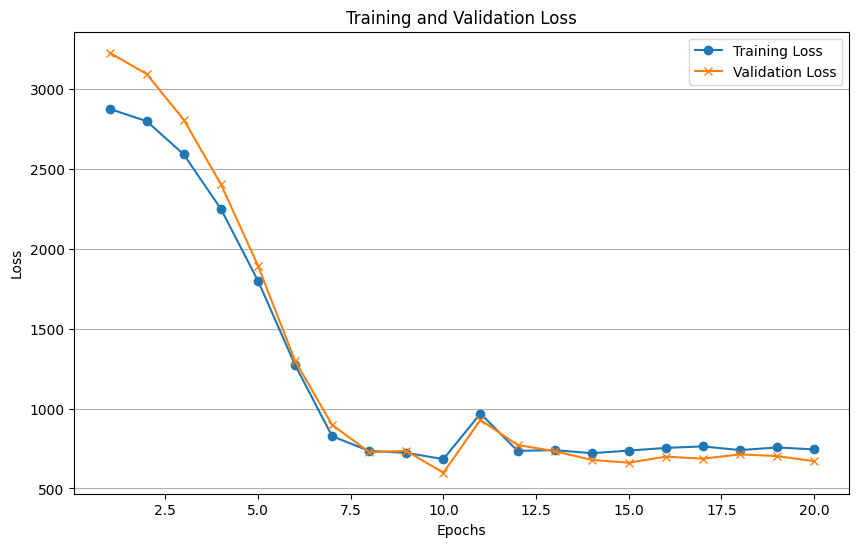

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='y')  
plt.show()

In [12]:
l,o = test()

Test eval:  544.9754231770834


In [13]:
o

tensor([3081.7314, 2531.1113, 2891.2209, 3435.7214, 2335.7927, 1634.1350,
        2528.5286, 3070.1626, 1630.2167, 3244.7029, 2699.5691, 2167.2854,
        2888.5786, 2524.2161, 3434.7258, 3255.9097, 2887.8633, 3790.1875,
        3079.2317, 2889.3176, 2161.5374, 4517.9312, 3255.5012, 3248.4187,
        3075.1165, 2161.1450, 2354.4871, 2703.7585, 3244.2207, 3600.4729,
        3053.5505, 2721.8235, 2874.9226, 3240.1521, 2890.4636, 3983.0828,
        3783.7336, 2330.0217, 2177.8113, 2720.3013, 2173.9841, 3603.4392,
        3788.4204, 2723.2004, 2881.3977, 3060.9011, 3071.8030, 2710.1487,
        2714.8899, 2332.6133, 2523.6248, 3250.7329, 2705.4622, 2544.4661,
        2176.2866, 3438.8286, 2180.2942, 2143.6257, 2708.7317, 3242.6086,
        3243.9468, 2149.7019, 3056.2324, 3254.6245, 2690.6208, 2525.0989,
        2893.6809, 2342.1431, 2370.6199, 3788.0559, 3081.4658, 2154.0144,
        3435.2205, 3243.7087, 2524.2471, 2887.5417, 3079.1306, 2714.3745,
        2542.5007, 3620.5964, 2897.960

In [14]:
right = 0
for i in range(len(o)-1):
    a =l[i] < o[i+1]
    b = l[i] < l[i+1]
    print(a,b)
    if a == b:
        right+= 1
print(right,len(o))

tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(False, device='cuda:1') tensor(False, device='cuda:1')
tensor(False, device='cuda:1') tensor(True, device='cuda:1')
tensor(True, dev